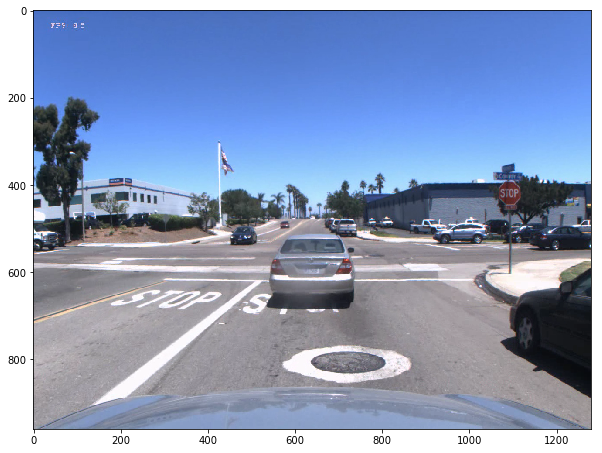

In [1]:
import cv2
import matplotlib.pyplot as plt
from utils.image_handler import preprocess_img
%matplotlib inline

img = cv2.cvtColor(cv2.imread('test_images/stop_1405106680.avi_image9.png'), cv2.COLOR_BGR2RGB)
# img = cv2.cvtColor(cv2.imread('/home/ubuntu/dataset/testing/2014-07-15_12-44/frameAnnotations-cam1.avi_annotations/warningUrdbl_1405466584.avi_image6.png'), cv2.COLOR_BGR2RGB)


plt.figure(figsize=(10, 10))
plt.imshow(img)

In [2]:
# Load labels
import numpy as np
from utils.parse_input import load_data

imgs, labels = load_data('data/training.txt')
LABELS           = np.unique(labels[:,1])
print(LABELS)

Number of ground truth boxes: 3672 boxes
['addedLane' 'bicyclesMayUseFullLane' 'curveLeft' 'curveRight' 'doNotEnter'
 'intersection' 'intersectionLaneControl' 'keepRight' 'laneEnds'
 'leftAndUTurnControl' 'merge' 'noLeftAndUTurn' 'noParking' 'noRightTurn'
 'noUTurn' 'pedestrianCrossing' 'school' 'signalAhead' 'speedBumpsAhead'
 'speedLimit15' 'speedLimit25' 'speedLimit30' 'speedLimit35' 'speedLimit40'
 'speedLimit45' 'speedLimit50' 'speedLimit60' 'stop' 'stopAhead'
 'yieldAhead' 'yieldToPedestrian']


In [3]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def sigmoid(x):
    return 1. / (1.  + np.exp(-x))

class BoundBox:
    def __init__(self, class_num):
        self.x, self.y, self.w, self.h, self.c = 0., 0., 0., 0., 0.
        self.probs = np.zeros((class_num,))
        
    def iou(self, box):
        intersection = self.intersect(box)
        union = self.w*self.h + box.w*box.h - intersection
        return intersection/union
        
    def intersect(self, box):
        width  = self.__overlap([self.x-self.w/2, self.x+self.w/2], [box.x-box.w/2, box.x+box.w/2])
        height = self.__overlap([self.y-self.h/2, self.y+self.h/2], [box.y-box.h/2, box.y+box.h/2])
        return width * height
        
    def __overlap(self, interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                return 0
            else:
                return min(x2,x4) - x1
            

In [7]:
import keras.backend as K
THRESHOLD = 0.6

def interpret_netout(image, netout):
    boxes = []
    GRID_H = 30
    GRID_W = 40
    netout = netout.reshape([30, 40, N_ANCHORS, N_CLASSES+5])
    # interpret the output by the network
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(N_ANCHORS):
                box = BoundBox(N_CLASSES)

                # first 5 weights for x, y, w, h and confidence
                box.x, box.y, box.w, box.h, box.c = netout[row,col,b,:5]

                box.x = (col+ sigmoid(box.x)) / GRID_W
                box.y = (row+ sigmoid(box.y)) / GRID_H
                box.w = ANCHORS[b][0] * np.exp(box.w)
                box.h = ANCHORS[b][1] * np.exp(box.h)
                box.c = sigmoid(box.c)

                # last 20 weights for class likelihoods
                classes = netout[row, col, b,5 :]
                box.probs = softmax(classes) * box.c
                box.probs *= box.probs > THRESHOLD

                boxes.append(box)

    # suppress non-maximal boxes
    for c in range(N_CLASSES):
        sorted_indices = list(reversed(np.argsort([box.probs[c] for box in boxes])))

        for i in xrange(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            if boxes[index_i].probs[c] == 0: 
                continue
            else:
                for j in xrange(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    if boxes[index_i].iou(boxes[index_j]) >= 0.4:
                        boxes[index_j].probs[c] = 0

    # draw the boxes using a threshold
    for box in boxes:
        max_indx = np.argmax(box.probs)
        max_prob = box.probs[max_indx]
        
        if max_prob > THRESHOLD:
            xmin  = int((box.x - box.w/2) * image.shape[1])
            xmax  = int((box.x + box.w/2) * image.shape[1])
            ymin  = int((box.y - box.h/2) * image.shape[0])
            ymax  = int((box.y + box.h/2) * image.shape[0])
            print("Found {} at {} with {} %".format(LABELS[max_indx], (xmin, ymin, xmax, ymax), box.c))

            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), [0, 255, 0], 2)
            cv2.putText(image, LABELS[max_indx], (xmin, ymin - 12), 0, 1e-3 * image.shape[0], (0,255,0), 2)
            
    return image

In [8]:
from model.yolov2 import YOLOv2, darknet19
from cfg import *
import tensorflow as tf

yolov2 = YOLOv2(feature_extractor=darknet19(), num_anchors=N_ANCHORS, num_classes=N_CLASSES)
model  = yolov2.model
model.load_weights('/home/ubuntu/dataset/backup/yolov2-epoch9-loss{2.80030410588}.weights')


Found leftAndUTurnControl at (1069, 357, 1070, 400) with 0.838343332578 %


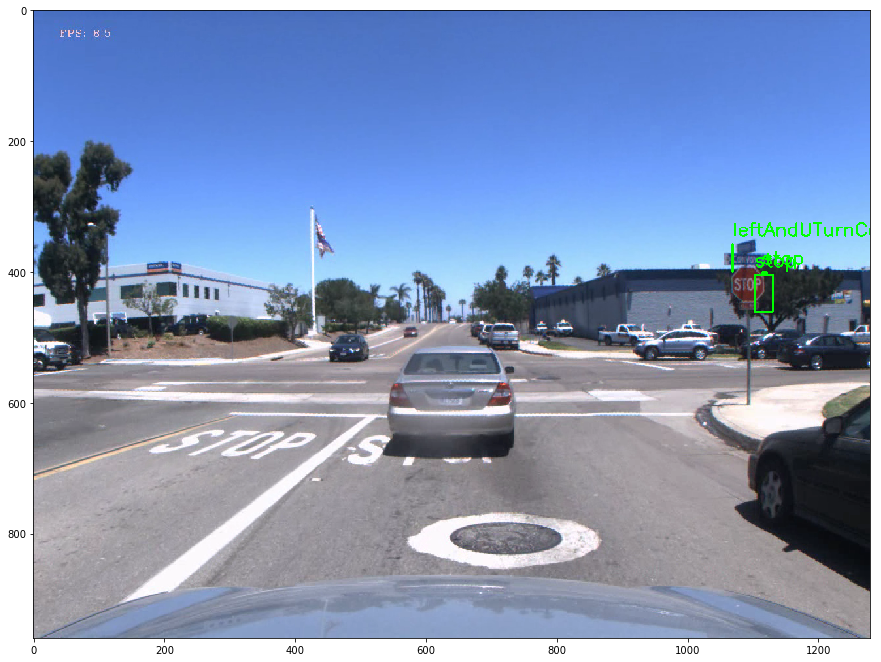

In [9]:
input_img = preprocess_img(img)
input_img = np.expand_dims(input_img, 0)

netout = model.predict(input_img)
result = interpret_netout(img, netout[0])
plt.figure(figsize=(15, 15))
plt.imshow(result)